In [9]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [10]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import InputExample, InputFeatures
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

In [12]:
df = pd.read_csv('Suicidal_redit.csv')  
df = df.dropna()

In [5]:
print(df)

                                                   Title  \
0      I'm looking for a girl I've met at the Polish ...   
1        I got a guy kicked off a domestic flight today.   
2      My youngest got in school suspension, Im so pr...   
3      I'm a cashier who switched from "sir/mam" to "...   
4      My whole class complimented me and didnt reali...   
...                                                  ...   
15471              Once I die, I can finally be at rest.   
15472                               I just want to stop.   
15473                                     Im still alive   
15474                I'm lonely but I can't stand people   
15475                       I dont even recognize myself   

                                                    Post         Label  
0      I've tried Polish spotted pages but I guess sh...  Non-Suicidal  
1      I was in a forward row as we were boarding for...  Non-Suicidal  
2      So according to witness testimonies a boy grab...  No

In [13]:
df['text'] = df['Title'] + " " + df['Post']
df = df[['text', 'Label']]

In [14]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

In [15]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['Label'], test_size=0.2)

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

c:\Users\prafu\.conda\envs\tf\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
train_labels = train_labels.astype(int).tolist()
val_labels = val_labels.astype(int).tolist()

In [18]:
def convert_data(texts, labels):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='tf'
    ), tf.convert_to_tensor(labels)

In [19]:
train_encodings, train_labels = convert_data(train_texts, train_labels)
val_encodings, val_labels = convert_data(val_texts, val_labels)

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels)).batch(4)
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), val_labels)).batch(4)

In [14]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

c:\Users\prafu\.conda\envs\tf\lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a 

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

In [16]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [18]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[early_stop]
)

Epoch 1/3
2849/2849 [==============================] - 317s 108ms/step - loss: 0.1805 - accuracy: 0.9322 - val_loss: 0.1672 - val_accuracy: 0.9347
Epoch 2/3
2849/2849 [==============================] - 307s 108ms/step - loss: 0.0733 - accuracy: 0.9748 - val_loss: 0.1618 - val_accuracy: 0.9403
Epoch 3/3
2849/2849 [==============================] - 307s 108ms/step - loss: 0.0394 - accuracy: 0.9874 - val_loss: 0.1378 - val_accuracy: 0.9568


In [19]:
loss, accuracy = model.evaluate(val_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

713/713 [==============================] - 21s 29ms/step - loss: 0.1378 - accuracy: 0.9568
Validation Loss: 0.13780680298805237
Validation Accuracy: 0.9568269848823547


In [22]:
pred_logits = model.predict(val_dataset).logits
pred_labels = np.argmax(pred_logits, axis=1)

713/713 [==============================] - 33s 41ms/step


In [23]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(val_labels, pred_labels))
print(accuracy_score(val_labels,pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1425
           1       0.99      0.99      0.99      1424

    accuracy                           0.99      2849
   macro avg       0.99      0.99      0.99      2849
weighted avg       0.99      0.99      0.99      2849

0.9880659880659881


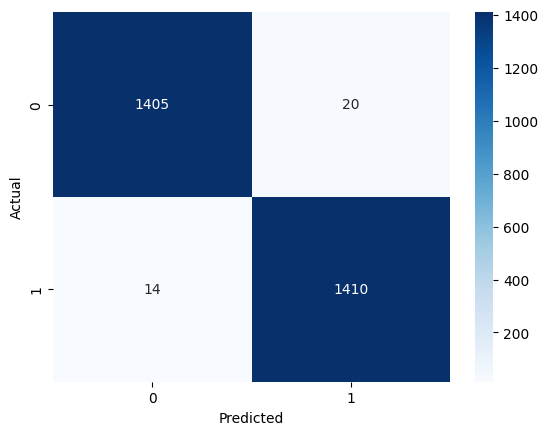

In [24]:
cm = confusion_matrix(val_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# Save the trained model
model.save_pretrained(r'C:\Personal_1\Praful\sem6\AIML\ml proj\Code')
tokenizer.save_pretrained(r'C:\Personal_1\Praful\sem6\AIML\ml proj\Code')

('C:\\Personal_1\\Praful\\sem6\\AIML\\ml proj\\Code\\tokenizer_config.json',
 'C:\\Personal_1\\Praful\\sem6\\AIML\\ml proj\\Code\\special_tokens_map.json',
 'C:\\Personal_1\\Praful\\sem6\\AIML\\ml proj\\Code\\vocab.txt',
 'C:\\Personal_1\\Praful\\sem6\\AIML\\ml proj\\Code\\added_tokens.json')

In [3]:
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
import tensorflow as tf

c:\Users\prafu\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = TFDistilBertForSequenceClassification.from_pretrained(r'C:\Personal_1\Praful\sem6\AIML\ml proj\Code')
tokenizer = DistilBertTokenizer.from_pretrained(r'C:\Personal_1\Praful\sem6\AIML\ml proj\Code')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at C:\Personal_1\Praful\sem6\AIML\ml proj\Code.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [11]:
sample_text = "My friend texted me thank you for everything at midnight"

# Tokenize the sample text
inputs = tokenizer(sample_text, return_tensors='tf', padding=True, truncation=True, max_length=128)
predictions = model(inputs)

In [12]:
predicted_class = tf.argmax(predictions.logits, axis=1).numpy()[0]

# Map to human-readable label
class_labels = {0: 'Not Suicidal', 1: 'Suicidal'}
print(f"Predicted class label: {class_labels[predicted_class]}")

Predicted class label: Not Suicidal
